In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
print(os.getcwd())
# print(os.listdir(os.getcwd()))
wrk_path = '/content/drive/My Drive/CMKL/00_colab/02_retina_UNet'
os.chdir(wrk_path)
# print(os.getcwd())

/content


In [3]:
import keras
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K 

import utils
from utils import *
import importlib
importlib.reload(utils)

import util
from util import *
# import importlib
importlib.reload(util)

import cv2
import h5py
import imageio
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython.display import Image
from keras import backend as K
# from tf.keras import Input, Model
# from tensorflow.keras.models import Model
from keras.engine import Model,Input
# from keras.layers import Input
from keras.layers import (
    Activation,
    Conv3D,Conv2D,UpSampling2D
    # Deconvolution3D,
    # MaxPooling3D,
    # UpSampling3D,
)
from keras.layers.convolutional import (Deconvolution3D,MaxPooling3D,MaxPooling2D,Deconvolution2D)
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.utils import to_categorical

In [4]:
from albumentations import (Compose,HorizontalFlip,ToFloat,VerticalFlip,RandomRotate90)
import glob

In [5]:
def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), 
                     epsilon=0.00001):
    dice_numerator = 2*K.sum(y_true*y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true**2, axis=axis) + K.sum(y_pred**2, axis = axis) + epsilon
    dice_coefficient =K.mean(dice_numerator/dice_denominator)
    return dice_coefficient

In [6]:
def dice_coef(y_true, y_pred,smooth=0.00001):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [7]:
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):
    """
    Compute mean soft dice loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_loss (float): computed value of dice loss.     
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # dice_numerator = 2*(K.sum(y_true*y_pred,axis=axis))+epsilon
    # dice_denominator = K.sum(y_true*y_true,axis=axis)+K.sum(y_pred*y_pred,axis=axis)+epsilon
    # dice_loss = 1-K.mean(dice_numerator/dice_denominator,axis=0)

    dice_numerator = 2*K.sum(y_true*y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true**2, axis=axis) + K.sum(y_pred**2, axis = axis) + epsilon
    dice_loss = 1 - K.mean(dice_numerator/dice_denominator)


    ### END CODE HERE ###

    return dice_loss

In [8]:
def plot_image_grid2(ori_image,image):
    fig, ax = plt.subplots(1, 2, figsize=[10,5])
    n = np.random.randint(ori_image.shape[2])
    ax[0].imshow(ori_image[:,:,0], cmap='Greys_r')
    ax[1].imshow(np.squeeze(image[:, :, n, :]))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    fig.subplots_adjust(wspace=10, hspace=0)
    fig.subplots_adjust(wspace=0, hspace=0)

In [9]:
base_dir = '/content/drive/My Drive/CMKL/datasets/IOSTAR/IOSTAR Vessel Segmentation Dataset/'
with open(base_dir + "config_processed_new.json") as json_file:
    config = json.load(json_file)
# config

In [10]:
BATCH_SIZE = 5
train_generator = utils.VolumeDataGenerator(config["train"], base_dir + "patches/",num_channels=1, batch_size=BATCH_SIZE, dim=(256, 256, 3),augmentations=None, verbose=0)
valid_generator = utils.VolumeDataGenerator(config["validation"], base_dir + "patches/",num_channels=1, batch_size=BATCH_SIZE, dim=(256, 256, 3),augmentations=None, verbose=0)
# train_generator = utils.VolumeDataGenerator(config["train"], base_dir + "patches/",num_channels=1, batch_size=BATCH_SIZE, dim=(256, 256, 3),augmentations = augmentation_train, verbose=0)
# valid_generator = utils.VolumeDataGenerator(config["validation"], base_dir + "patches/",num_channels=1, batch_size=BATCH_SIZE, dim=(256, 256, 3),augmentations = augmentation_test, verbose=0)

In [11]:
# model = utils.unet_model_3d(loss_function=soft_dice_loss, metrics=[dice_coefficient],input_shape=(256, 256, 3), n_base_filters=32)
# model2 = util.unet_model_3d(loss_function=soft_dice_loss,input_shape=(1,256, 256, 3), metrics=[dice_coef],pool_size=(2, 2, 1),depth=6)
model2 = util.unet_model_3d(loss_function=[soft_dice_loss],input_shape=(1,256, 256, 3), metrics=[dice_coefficient,'accuracy'],pool_size=(2, 2, 1),batch_normalization=False,drop_out=False,depth=4, n_labels=3)

model2.load_weights(os.path.join(os.getcwd(),'middle_weight7_preprocessed_conv3d_depth4_batch16_btnorm_dropout.hdf5'))

Tensor("input_1:0", shape=(None, 1, 256, 256, 3), dtype=float32)
hey 0 (None, 32, 256, 256, 3) (None, 64, 256, 256, 3) (None, 64, 128, 128, 3)
hey 1 (None, 64, 128, 128, 3) (None, 128, 128, 128, 3) (None, 128, 64, 64, 3)
hey 2 (None, 128, 64, 64, 3) (None, 256, 64, 64, 3) (None, 256, 32, 32, 3)
hey 3 (None, 256, 32, 32, 3) (None, 512, 32, 32, 3) (None, 512, 32, 32, 3)
(None, 512, 64, 64, 3) (None, 256, 64, 64, 3)
(None, 256, 128, 128, 3) (None, 128, 128, 128, 3)
(None, 128, 256, 256, 3) (None, 64, 256, 256, 3)


In [ ]:
val_loss, val_dice = model2.evaluate_generator(valid_generator)

print(f"validation soft dice loss: {val_loss:.4f}")
print(f"validation dice coefficient: {val_dice:.4f}")

ValueError: ignored

In [ ]:
tf.compat.v1.disable_eager_execution()
sess = tf.compat.v1.Session()
with sess.as_default():
  dc = dice_coefficient(patch_pred[0,:,:,:],msk.astype(np.float32))
  print(pred.shape,label.shape)
  print(f"dice_coef",dc.eval())
df = get_sens_spec_df(patch_pred[0,:,:,:],msk)

(2, 2, 2, 3) (2, 2, 2, 3)
dice_coef 0.6099022


NameError: ignored

In [ ]:
x,y = valid_generator.__getitem__(4)
# x,y = train_generator.__getitem__(3)

In [ ]:
print(x.shape,y.shape)
ix = 1
img = x[ix,:,:,:,:]
msk = y[ix,:,:,:,:]
print(img.flatten()[0:5])
# img = ((img*0.224)+0.456)*255
print(img.flatten()[0:5])
print(img.shape)
X_norm_with_batch_dimension = np.expand_dims(img, axis=0)
patch_pred = model2.predict(X_norm_with_batch_dimension)
# print(np.unique(X_norm_with_batch_dimension))
print(X_norm_with_batch_dimension.shape,patch_pred.shape,msk.shape)

tst = np.moveaxis(patch_pred[0,:,:,:,:],0,-1)
print(np.mean(tst[:,:,:,0]))
print(np.mean(tst[:,:,:,1]))
print(np.mean(tst[:,:,:,2]))

thr0 = 0.5
thr1 = 0.5
thr2 = 0.5
thrs = [thr0,thr1,thr2]
predicted_msk = predict_viz(tst,thrs)
print(tst.shape,predicted_msk.shape)
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(20,10))
ax[0].imshow(img[0,:,:,0], cmap='Greys_r')
ax[1].imshow(np.moveaxis(msk,0,-1)[:,:,0,:])
ax[2].imshow(predicted_msk[:,:,0,:])
ax[3].imshow(predicted_msk[:,:,1,:])
ax[4].imshow(predicted_msk[:,:,2,:])
ax[0].set_title('patched image',color='white')
ax[1].set_title('groudtruth',color='white')
ax[2].set_title('predicted',color='white')

(5, 1, 256, 256, 3) (5, 3, 256, 256, 3)
[207.  94.  28. 206.  94.]
[207.  94.  28. 206.  94.]
(1, 256, 256, 3)


In [ ]:
type(patch_pred)

numpy.ndarray

In [ ]:
patch_pred.shape,msk.shape

((1, 3, 256, 256, 3), (3, 256, 256, 3))

In [ ]:
ix = 100
iy = 250
print(patch_pred[0,:,ix,iy,:])
print(msk[:,ix,iy,:])

[[0. 0. 0.]
 [0. 0. 0.]
 [1. 1. 1.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [1. 1. 1.]]


In [ ]:
!pip install keract

In [ ]:
from keract import get_activations,display_activations
activations = get_activations(model2, X_norm_with_batch_dimension)

In [ ]:
# display_activations(activations, cmap="gray", save=False)

In [ ]:
# from keract import display_activations
# display_activations(activations,cmap='gray', save=False)

In [ ]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def compute_class_sens_spec(pred, label, class_num):
    """
    Compute sensitivity and specificity for a particular example
    for a given class.

    Args:
        pred (np.array): binary arrary of predictions, shape is
                         (num classes, height, width, depth).
        label (np.array): binary array of labels, shape is
                          (num classes, height, width, depth).
        class_num (int): number between 0 - (num_classes -1) which says
                         which prediction class to compute statistics
                         for.

    Returns:
        sensitivity (float): precision for given class_num.
        specificity (float): recall for given class_num
    """

    # extract sub-array for specified class
    class_pred = pred[class_num]
    class_label = label[class_num]

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # compute:
    
    # true positives
    tp = np.sum((class_pred == 1)&(class_label==1))

    # true negatives
    tn = np.sum((class_pred == 0)&(class_label==0))
    
    #false positives
    fp = np.sum((class_pred == 1)&(class_label==0))
    
    # false negatives
    fn = np.sum((class_pred == 0)&(class_label==1))

    # compute sensitivity and specificity
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)

    ### END CODE HERE ###

    return sensitivity, specificity

In [ ]:
def get_sens_spec_df(pred, label):
    patch_metrics = pd.DataFrame(
        columns = ['OD', 
                   'VS', 
                   'FL'], 
        index = ['Sensitivity',
                 'Specificity'])
    
    for i, class_name in enumerate(patch_metrics.columns):
        sens, spec = compute_class_sens_spec(pred, label, i)
        patch_metrics.loc['Sensitivity', class_name] = round(sens,4)
        patch_metrics.loc['Specificity', class_name] = round(spec,4)

    return patch_metrics

In [ ]:
df = get_sens_spec_df(predicted_msk[:,:,0,:],msk)
print(df)

NameError: ignored

In [ ]:
def prepare_image_label(img_path,lbl_vsl_path,lbl_od_path,lbl_msk_path,plot_before):
    # 1) read images
    img = cv2.imread(img_path) #BGR
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #RGB
    lbl_vsl = cv2.imread(lbl_vsl_path,0)
    lbl_od = cv2.imread(lbl_od_path,0)
    lbl_msk = cv2.imread(lbl_msk_path,0)
    if plot_before:
        fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(20,5))
        ax[0].imshow(img)
        ax[1].imshow(lbl_vsl, cmap='Greys_r')
        ax[2].imshow(lbl_od, cmap='Greys_r')
        ax[3].imshow(lbl_msk, cmap='Greys_r')
        ax[0].set_title('original image')
        ax[1].set_title('vessel')
        ax[2].set_title('optic disc')
        ax[3].set_title('vitreous body')
        plt.show()
        
    # 2) assign optic disc to 1
    lbl_od[lbl_od==lbl_msk]=255
    lbl_od[lbl_od==0]=1 # optic disc
    lbl_od[lbl_od==255]=0
    # 3) assign vessel to 2
    lbl_vsl
    lbl_vsl[lbl_vsl == 255] = 2 # vessel
    lbl_vsl[lbl_od==1] = 1
    # 4) assign floor-eye layer to 3
    lbl_msk[lbl_msk==255]=3 # eye-floor layer
    lbl_msk[lbl_od==1]=1
    lbl_msk[lbl_vsl==2]=2
    # 5) bitwise_or operation for all label image
    lbl_cmb = cv2.bitwise_or(lbl_od,lbl_vsl)
    lbl_cmb = cv2.bitwise_or(lbl_cmb,lbl_msk)
    lbl_cmb_cvt = cv2.cvtColor(lbl_cmb,cv2.COLOR_GRAY2RGB)
    return img,lbl_cmb_cvt

In [ ]:
def get_labeled_image3(imagex, label, is_categorical=False):
#     print(is_categorical,image.shape,label.shape)
    image = imagex[:,:,:,0].copy()
    if not is_categorical:
        label = to_categorical(label, num_classes=4).astype(np.uint8)
#         print(label.shape)
    image = cv2.normalize(image, None, alpha=0, beta=255,
                          norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(
        np.uint8)
    

    labeled_image = np.zeros_like(label[:, :, :, 1:])
#     print(image.shape,label.shape,labeled_image.shape)
    # remove tumor part from image
    labeled_image[:, :, :, 0] = image * (label[:, :, :, 0])
    labeled_image[:, :, :, 1] = image * (label[:, :, :, 0])
    labeled_image[:, :, :, 2] = image * (label[:, :, :, 0])

    # color labels
    labeled_image += label[:, :, :, 1:] * 255
#     print(image.shape)
    return labeled_image

In [19]:
def predict_viz(patch_pred2,thrs):
  for i in range(0,patch_pred2.shape[-1]): # n_class
    thr = thrs[i]
    patch_pred2[:,:,:,i][patch_pred2[:,:,:,i]>thr]=1
    patch_pred2[:,:,:,i][patch_pred2[:,:,:,i]<=thr]=0
  return patch_pred2

In [37]:
def predict_and_viz(model, threshold,image,flag_plot=0, label=None):
    raw_shape_w,raw_shape_h = image.shape[0],image.shape[1]
    
    # print('groundtruth shape ',image_labeled.shape)
    model_label = np.zeros([3, raw_shape_w*2, raw_shape_h*2, 3])
    count_pred = 0
    for x in range(0, image.shape[0], 256):
        # print(x)
        for y in range(0, image.shape[1], 256):
              # print('\t',y)
              patch = np.zeros([1, 256, 256, 3])
              p = np.moveaxis(image[x: x + 256, y: y + 256, :], 3, 0)
              patch[:, 0:p.shape[1], 0:p.shape[2], 0:p.shape[3]] = p
              # print(patch.shape,np.expand_dims(patch, 0).shape)
              pred = model.predict(np.expand_dims(patch, 0))
              # print(pred.shape)
              model_label[:, x:x + p.shape[1],
              y:y + p.shape[2],
              :] += pred[0][:, :p.shape[1], :p.shape[2],
                                    :]
              count_pred+=1
    
    
    model_label = np.moveaxis(model_label,0,-1)
    model_labeled_image = model_label[0:raw_shape_w,0:raw_shape_h,:,:]
    thr0 = threshold
    thr1 = threshold
    thr2 = threshold
    thrs = [thr0,thr1,thr2]
    predicted_msk_thresholded = predict_viz(model_labeled_image,thrs)

    if flag_plot:
    
      if label is not None:
        image_labeled = get_labeled_image3(image.copy(), label.copy())
        fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(30,10))
        ax[0].imshow(image[:,:,:,0])
        ax[1].imshow(image_labeled[:,:,0,:])
        ax[2].imshow(predicted_msk_thresholded[:,:,0,:])
        ax[0].set_title('image',color='white')
        ax[1].set_title('groundtruth',color='white')
        ax[2].set_title('predicted mask',color='white')
        plt.show()
        fig.subplots_adjust(wspace=0, hspace=.12)
        for i in range(0,3):
          ax[i].set_xticks([])
          ax[i].set_yticks([])
      else:
        fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
        ax[0].imshow(image[:,:,:,0])
        ax[1].imshow(predicted_msk_thresholded[:,:,0,:])
        ax[0].set_title('image',color='white')
        ax[1].set_title('predicted mask',color='white')
        plt.show()
        fig.subplots_adjust(wspace=0, hspace=.12)
        for i in range(0,2):
          ax[i].set_xticks([])
          ax[i].set_yticks([])
        fig.savefig()

    return predicted_msk_thresholded

STAR 02


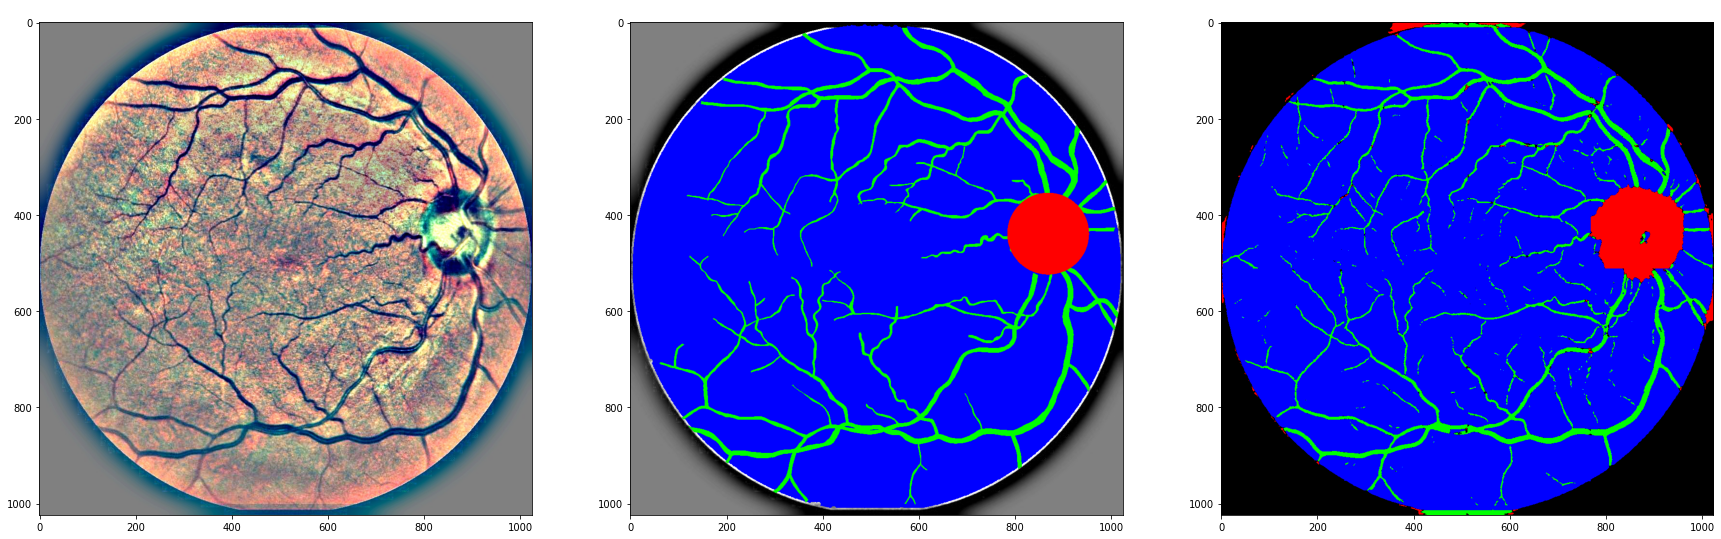

In [ ]:
main_dir = '/content/drive/My Drive/CMKL/datasets/IOSTAR/IOSTAR Vessel Segmentation Dataset'
images = os.listdir(os.path.join(main_dir,'image_preprocessed'))
i_img = len(images)-5
img_name = images[i_img]

img_name = img_name.split('_')[0]
print(img_name)
#     img_name = 'STAR 45'
img_path = glob.glob(os.path.join(main_dir,'image_preprocessed',img_name+'*'))[0]
lbl_vsl_path = glob.glob(os.path.join(main_dir,'GT',img_name+'*'))[0]
lbl_od_path = glob.glob(os.path.join(main_dir,'mask_OD',img_name+'*'))[0]
lbl_msk_path = glob.glob(os.path.join(main_dir,'mask',img_name+'*'))[0]
plot_before = 0
img,lbl_cmb_all = prepare_image_label(img_path,lbl_vsl_path,lbl_od_path,lbl_msk_path,plot_before)

img2 = np.expand_dims(img,-1)
pred = predict_and_viz(model2, .5,img2,lbl_cmb_all)

In [12]:
def preprocessing_bengraham(img,alpha,beta,gamma):
    img = cv2.cvtColor(img,cv2.cv2.COLOR_BGR2RGB)
    img2 = cv2.GaussianBlur(img,(0,0),27)
    img = cv2.addWeighted(img,alpha,img2,beta,gamma)
    return img

In [33]:
alpha,beta,gamma = 7,-7,128

test_dir = '/content/drive/My Drive/CMKL/datasets/quality/train/bad'
img_names = os.listdir(test_dir)
# img_name = 'ebe4ae2e-bd5a-4ccf-bbc7-de4815807be4.4'+'.png'
# img = cv2.imread(os.path.join(test_dir,img_name))
# img2 = preprocessing_bengraham(img,alpha,beta,gamma)

In [31]:
img_names

'ebe4ae2e-bd5a-4ccf-bbc7-de4815807be4.10.png'

In [41]:
for img_name in img_names:
  if '.png' not in img_name:
    continue
  img = cv2.imread(os.path.join(test_dir,img_name))
  img2 = preprocessing_bengraham(img,alpha,beta,gamma)
  ix = np.where(imgx2<25)
  for i,j in zip(ix[0],ix[1]):
    img2[i,j,:]=0
  flag_plot=0
  pred = predict_and_viz(model2, .8,np.expand_dims(img2,-1),flag_plot,None)
# img2[img2<=25]=0
  
  path_out = os.path.join(test_dir,'..','output') 
  
  fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(30,10))
  ax[0].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  ax[1].imshow(img2)
  ax[2].imshow(pred[:,:,0,:])
  fig.savefig(os.path.join(test_dir,'..','output','predicted_'+img_name+'.png'))
  # break

In [22]:
# imgx = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# imgx2 = imgx.copy()
# imgx2 = cv2.cvtColor(imgx2,cv2.COLOR_RGB2GRAY)
# imgx2[imgx2>25]=255
# plt.imshow(imgx2)
# # plt.hist(imgx2)

In [15]:
ix = np.where(imgx2<25)
for i,j in zip(ix[0],ix[1]):
  img2[i,j,:]=0
  # break

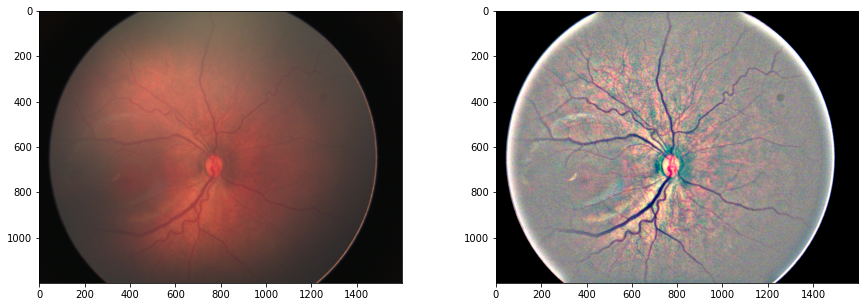

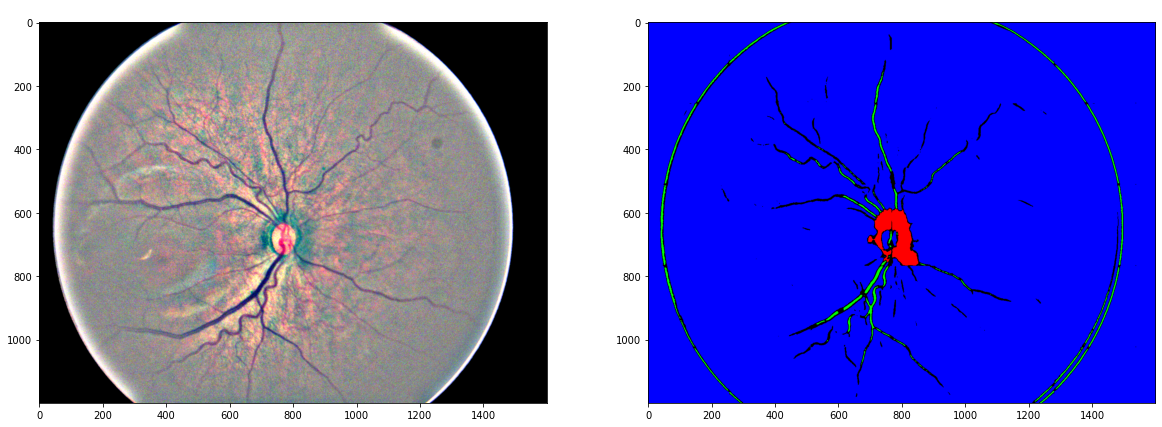

In [ ]:
# pred = predict_and_viz(model2, .1,np.expand_dims(img2,-1),None)

In [ ]:
pred[0,0,:,:]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])